In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=16, color='k')
    
    delta = y_cvl-p_y_cvl
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=16, color='k')

    delta = y_tst-p_y_tst
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=16, color='k')

    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=16)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 


    fig.savefig(plotName+".png")
    plt.show()
#######################################

In [2]:
## loading data
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

Feature Importances:  [0.03613506 0.02934526 0.05249333 0.88202634]
g_r 	-->  3.61%
r_i 	-->  2.93%
i_z 	-->  5.25%
pc0 	-->  88.20%


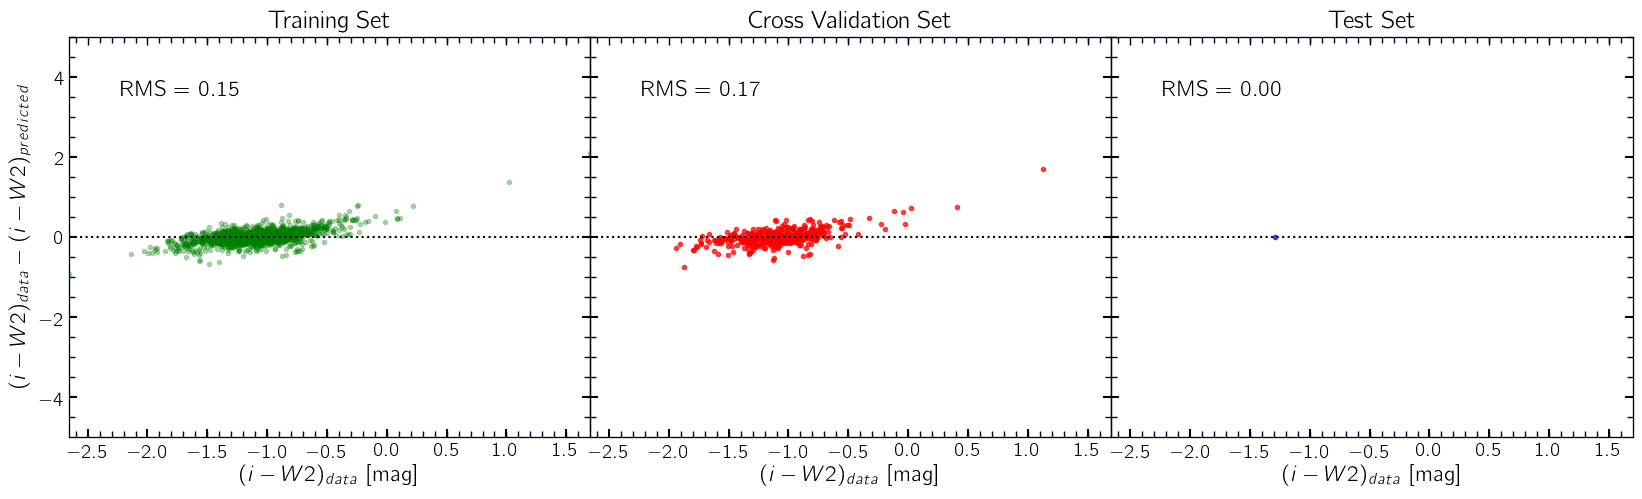

In [152]:
## Sample management
## table_tst: Test table
## table_cvl: Cross Validation table
## table_trn: Training Table
## N_test: Number of test data points
## N_cross: Number of cross validation data points
## Seed_test: Random seed number to choose the test sample (i.e. fixed=0)
## Seed_cross: Random seed number to choose the cross validation sample 
##                     (can be changed to see the algorithm performance)
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=400, N_test=1)
import pylab as py

################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'i_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=15
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i-W2'
text_unit = 'mag'
x0 = np.min(table_trn[output])
x1 = np.max(table_trn[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-5,5]

d = np.abs(p_y_trn-y_trn)
tt = 0.6
indx, = np.where(d<tt)
X = y_trn[indx]
Xp = p_y_trn[indx]
Y = X-Xp
m, b = np.polyfit(X,Y, 1)

m=0
b=0

p_y_trn = (p_y_trn+b)/(1-m)
p_y_cvl = (p_y_cvl+b)/(1-m)
p_y_tst = (p_y_tst+b)/(1-m)

makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

54690 72 0.771 13.066
52 13.031554816263567 [-2.44169218e-09]
Delta W: 0.03
-0.0004590574014106119
-0.0005630102147128335
-0.0008527682351051058
-0.0012403677741780472


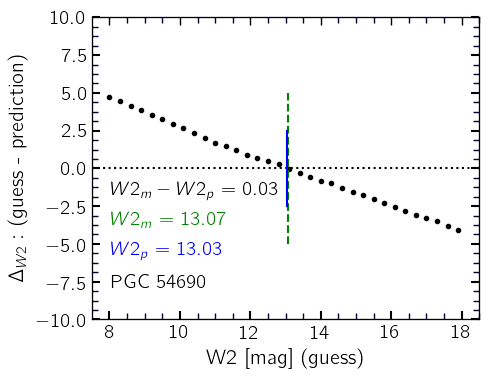

In [153]:
j = 50
PGC  = table_cvl['pgc'][j]
W2   = table_cvl['w2'][j]
INC  = table_cvl["inc"][j]
P0   = table_cvl["pc0"][j]
M21  = table_cvl["m21"][j]
M0   = table_cvl["logWimx"][j]
WBA  = table_cvl["Wba"][j]
WBAp = table_cvl["Wbap"][j]
R50  = table_cvl["R50_w2"][j]
R50p = table_cvl["R50_w2p"][j]

print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_cvl, regr, features, output, index=j, useFullPredictions=True, m=m, b=b)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')


ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_ylim([-10,10])
xlim = ax.get_xlim()
ylim = ax.get_ylim()

set_axes([ax], xlim, ylim)


x0 = 0.95*xlim[0]+0.05*xlim[1]
y0 = 0.9*ylim[0]+0.1*ylim[1]
ax.text(x0,y0, 'PGC '+'%d'%PGC, fontsize=14, color='k')


ax.set_xlabel('W2 [mag] (guess)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (guess - prediction)', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    
    
    x0 = 0.95*xlim[0]+0.05*xlim[1]
    y0 = 0.6*ylim[0]+0.40*ylim[1]
    ax.text(x0,y0, r'$W2_m-W2_p$'+' = '+'%.2f'%(W2-w2p), fontsize=14, color='k')
    y0 = 0.7*ylim[0]+0.30*ylim[1]
    ax.text(x0,y0, r'$W2_m$'+' = '+'%.2f'%(W2), fontsize=14, color='green')
    y0 = 0.8*ylim[0]+0.20*ylim[1]
    ax.text(x0,y0, r'$W2_p$'+' = '+'%.2f'%w2p, fontsize=14, color='blue')    
    
    
    
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'b-') 


In [139]:
a = time.time()

W2_lst = []
w2p_lst = []

for j in range(len(table_cvl['pgc'])):
    
    PGC = table_cvl['pgc'][j]
    W2  = table_cvl['w2'][j]
    INC = table_cvl["inc"][j]
    P0  = table_cvl["pc0"][j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_cvl, regr, features, output, index=j, useFullPredictions=True, m=m, b=b)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!', PGC
        w2p=0
    else:
        w2p, N = out
        w2p=w2p[0]
    W2_lst.append(W2)
    w2p_lst.append(w2p)
    ###############################################
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)

print "Time: ", time.time()-a

Not solvable ... !!! 44182
Time:  951.324681997


0.5177975749273249


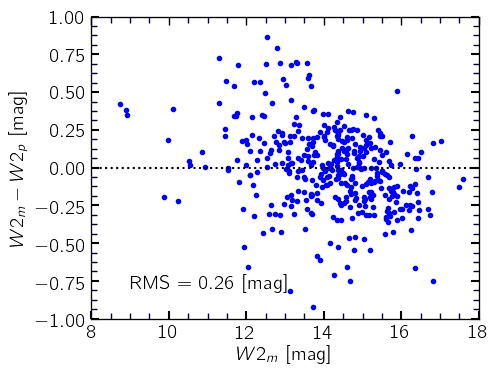

In [141]:
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(W2_lst, W2_lst-w2p_lst, 'b.')


ax.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [8,18], [-1,1])

XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<0.7)]
mu = 0
sigma = np.std(XX)

ax.text(9,-0.8, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')

print np.std(W2_lst-w2p_lst)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''), Text(0,0,'50'), Text(0,0,'100'), Text(0,0,'150')]

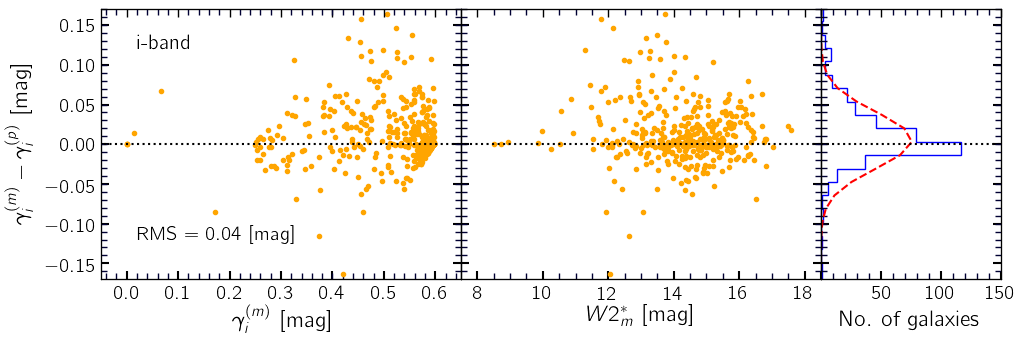

In [175]:
#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
A_m = np.zeros(N)
A_p = np.zeros(N)

for j in range(N):
    
    w2p  = w2p_lst[j]
    w2m  = W2_lst[j]
    M21  = table_cvl["m21"][j]
    M0   = table_cvl["logWimx"][j]
    WBA  = table_cvl["Wba"][j]
    R50  = table_cvl["R50_w2"][j]
    WBAp  = table_cvl["Wbap"][j]
    R50p  = table_cvl["R50_w2p"][j]
    INC  = table_cvl["inc"][j]
    
    ## MEASURED
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    A_m[j], gamma_m[j] = redCorrect(INC, P0, band1='i', band2='w2', getGamma=True)
    
    ## PREDICTED
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBAp, R50p)
    A_p[j], gamma_p[j] = redCorrect(INC, P0, band1='i', band2='w2', getGamma=True)

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orange')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='orange')


XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.15)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,150], [-0.17,0.17])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_i^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.02,0.12, 'i-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [-0.05,0.65], [-0.17,0.17])
set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''), Text(0,0,'20'), Text(0,0,'40'), Text(0,0,'60'), Text(0,0,'80')]

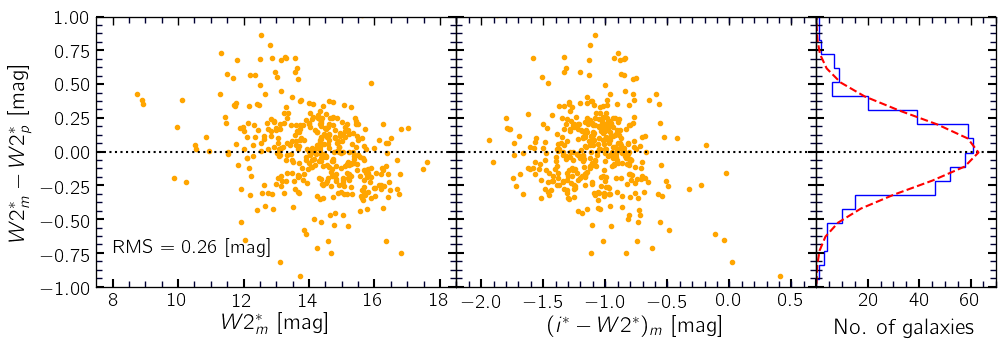

In [170]:
#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='orange')
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.5,18.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

ax_.plot(table_cvl["i_w2"], W2_lst-w2p_lst, '.', color='orange')
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [-2.2,0.7], [-1,1])
ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<0.75)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,70], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)